## 문장 기호 자동 추가
문장이 주어졌을 때 문장 부호인 마침표('.')와 쉼표(',') 를 자동으로 추가하는 프로그램을 작성하는 것을 목표로 한다.  
이를 수행하기 위하여 복수의 문장을 입력 받아 Deep Learning Network 을 구성하여 training 하고,  
예시 문장에 대하여 적용하여 실제 동작을 잘 수행하는지 확인 한다  

### data 추상화

예를 들면, 아래와 같이 문장이 주어졌다고 가정하자.  
'''
   "오늘 걷지 않는다면 내일은 뛰어야 한다"
'''
우리가 원하는 결과는 아래와 같을 것이다.  
'''
   "오늘 걷지 않는다면, 내일은 뛰어야 한다."
'''

   
입력된 문장에서 target 을 아래와 같이 구성한다  

```
 문자 : '<nop>'  
   . : '.'  
   , : ','  
```

즉, 위의 예를 다시 쓰면 아래처럼 될 것이다. 
```
   오 : '<nop>'
   늘 : '<nop>'
   ... 
   면 : '<nop>'
   , : ','
   내 : '<nop>'
   ...
   다 : '<nop>'
   . : '.'
```
```
"오늘 걷지 않는다면 내일은 뛰어야 한다"
```
가 들어오면, 
<nop>, ',', '.' 로 이루어진 리스트가 출력되는 문제로 추상화할 수 있다. 
    
     "그러므로 입력 문장에 대하여 이에 대응되는 '<nop>', '.', ',' 로 구성된 출력을 구하는 문제로 정의 할 수 있다.  \n",
    "입력은 문장으로 이루어지고, 출력은 세개의 character 로 구성된 list 가 될 것이다.  \n",
    "  \n",
    "character 단위로 다루면 문장의 의미 파악이 되지 않을 것으로 생각된다. \n",
    "더 좋은 결과를 얻기 위하여서는 문장을 해석해서 처리하는 것이 좋을 것 같으나,  \n",
    "문제를 단순화 하기 위하여 문장을 character 단위로 다루기로 한다.  \n",
    


    



In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
import tensorflow as tf

print(tf.__version__)

1.3.0


### preprocessing 

입력은 한글로 된 세종 코퍼스에서 입력 받아 처리하였다.  
입력된 data 중 <p> </p> 로 묶인 문장만을 사용하였다. 

"우선 trainging 을 위하여 입력한 data 를 처리해야 한다. 문장을 입력받으면, 우선 character vector 를 구성한다.  \n",
    "한글의 문자는 그 수가 많으므로,  \n",
    "training data 의 빈도수를 보고, 입력 문자의\n"  
character 의 빈도수를 보았을 때, character 에 대한 입력 dictionary 를 200 으로 사용하였다. 

length of paragraph:  875


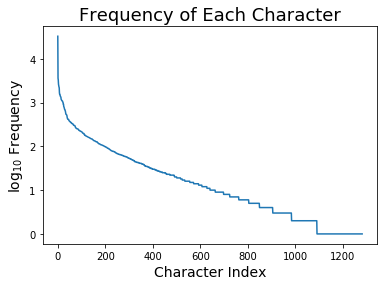

In [6]:
import math, numpy as np, matplotlib.pyplot as plt
import data

rawdata = data.read_data("data/4BE00006.txt")

sorted_char_map = data.get_sorted_char_map(rawdata)

plt.title('Frequency of Each Character', fontsize=18)
plt.plot(np.array([math.log10(k[1]) for k in sorted_char_map]))
plt.ylabel('$\log_{10}$ Frequency', fontsize=14)
plt.xlabel('Character Index', fontsize=14)
plt.show()

### 네트워크 구성 
입력은 100 개의 character 이고, 이러한 입력이 들어올 때  
출력은 세 개의 케이스 ('<nop>', '.', ',') 중 하나를 출력하도록 네트워크를 구성한다. 

문장을 training하여 문장 부호를 예측하는 모델은, 
각 문장의 character 들은 그 이전에 나온 character 와 밀접한 관계를 가지므로 네트워크는 RNN 을 사용한다.  
RNN 의 cell 은 vanishing gradient 의 영향을 줄일 수 있는 LSTM 을 사용한다.
Layer 를 2 layer를 사용하였고, hidden size 는 128 로 설정하였다. 

100 개중 1 * 128 * 128 * 3 개중 1의 네트워크가 될 것이다. 


In [3]:
import data
import utils
import model

print("=== start prediction of puncuation ===")
rawdata = data.read_data("data/4BE00006.txt")

dic_size = 100
input_chars, output_chars = data.make_dic(rawdata, dic_size)

text = rawdata

char2vec = utils.Char2Vec(chars=input_chars, add_unknown=True)
output_char2vec = utils.Char2Vec(chars=output_chars)
input_size = char2vec.size
output_size = output_char2vec.size

# make and run multi layer LSTM network
hidden_size = 128


=== start prediction of puncuation ===
length of paragraph:  875


In [4]:
import tensorflow as tf 
import model 

seq_length = 30
training_dataset, valid_dataset = model.make_sequences(text, char2vec, output_char2vec, seq_length)

input_batch = training_dataset.input_batch
target_batch = training_dataset.target_batch
seq_lens = training_dataset.seq_lens

batch_size = len(input_batch)

tf.reset_default_graph()
X = tf.placeholder(tf.int32, [None, seq_length])  # X data
Y = tf.placeholder(tf.int32, [None, seq_length])  # Y label

Seqlen = tf.placeholder(tf.int32, [None])

Weight = tf.placeholder(tf.float32, [None, None])  # Weight
X_one_hot = tf.one_hot(X, input_size)  # one hot: 1 -> 0 1 0 0 0 0 0 0 0 0

with tf.variable_scope('cell_def'):
    cell1 = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
    # cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=0.5)
    cell2 = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)

    multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
with tf.variable_scope('rnn_def'):
    outputs, _states = tf.nn.dynamic_rnn(
        multi_cell, X_one_hot,  dtype=tf.float32, sequence_length=Seqlen)

rnnmodel = tf.layers.dense(outputs, output_size, activation=None)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=rnnmodel, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

weights = model.make_weight_mat(input_batch, seq_lens)

prediction = tf.argmax(rnnmodel, axis=2) # axis 2 ??
target = tf.cast(Y, tf.int64) #Y #tf.argmax(Y, axis=1) # axis 2 ??



--- learning start ---
epoch # 9
accuracy: 0.968074
Key: <nop>	Prec: 100.0%	Recall: 6.8	F-Score:  98.4%
Key:   ,	Prec:   0.0%	Recall: 0.0	F-Score:   N/A
Key:   .	Prec:   0.0%	Recall: 0.0	F-Score:   N/A
epoch # 19
accuracy: 0.968074
Key: <nop>	Prec: 100.0%	Recall: 6.8	F-Score:  98.4%
Key:   ,	Prec:   0.0%	Recall: 0.0	F-Score:   N/A
Key:   .	Prec:   0.0%	Recall: 0.0	F-Score:   N/A


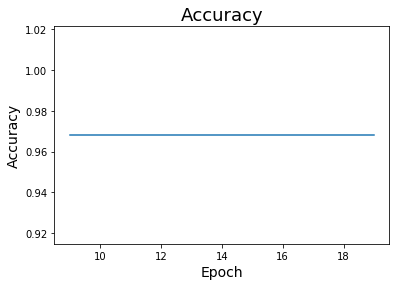

NameError: name 'self' is not defined

In [8]:
import math, numpy as np, matplotlib.pyplot as plt

sess = tf.Session()
sess.run(tf.global_variables_initializer())
accuracyset = []
print("--- learning start ---")
for epoch in range(20):
    l, loss = sess.run([optimizer, cost], feed_dict={X:input_batch, Y:target_batch, Weight:weights, Seqlen:seq_lens})

    if epoch%10 == 9:
        print("epoch #", epoch)

        valid_weights = model.make_weight_mat(valid_dataset.input_batch, valid_dataset.seq_lens)

        result = sess.run(prediction, feed_dict={X: valid_dataset.input_batch, Y:valid_dataset.target_batch, Weight:valid_weights, Seqlen:valid_dataset.seq_lens})
        sess.run(target, feed_dict={Y: valid_dataset.target_batch})
        is_correct = tf.equal(prediction, target)

        accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
        accuracy_ret = sess.run(accuracy, feed_dict={X: valid_dataset.input_batch, Y:valid_dataset.target_batch, Weight:valid_weights, Seqlen:valid_dataset.seq_lens})
        print("accuracy:", accuracy_ret)
        accuracyset.append([epoch, accuracy_ret])
        result_output_mat = []
        target_output_mat = []
        for index, sq in enumerate(result):
            result_output, target_output = model.compare_sentence(output_char2vec, valid_dataset.target_batch[index], valid_dataset.input_source[index], sq, True if epoch == 999 else False)
            result_output_mat.append(result_output)
            target_output_mat.append(target_output)

        utils.print_pc_matrix(result_output_mat, target_output_mat)
print("--- learning end ---")

plt.title('Accuracy', fontsize=18)
plt.plot([k[0] for k in accuracyset], [k[1] for k in accuracyset])
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.show()        
        
test_sentence = list("예를 들어, 이와 같은 경우 불법이 확실하다.")
test_dataset, _ = model.make_sequences(test_sentence, char2vec, output_char2vec, seq_length, make_valid=False)
weights = model.make_weight_mat(test_dataset.input_batch, test_dataset.seq_lens)

# print(test_dataset.input_batch)
# print(test_dataset.target_batch)

result = sess.run(prediction, feed_dict={X: test_dataset.input_batch, Y: test_dataset.target_batch,
                                                   Weight: weights, Seqlen: test_dataset.seq_lens})
# print(result)

for index, sq in enumerate(result):
    result_output, target_output = model.compare_sentence(output_char2vec, test_dataset.target_batch[index],
                                                         test_dataset.input_source[index], sq, printable=True)


### Reference 
https://github.com/episodeyang/deep-auto-punctuation  
https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb
